In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 415242848595371060, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 10160593258349479885
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:83:00.0, compute capability: 6.1", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 11576651770500198243
 physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:84:00.0, compute capability: 6.1", name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 10005900258755929197
 physical_device_desc: "device: 2, name: GeForce GTX 1080 Ti, pci bus id: 0000:87:00.0, compute capability: 6.1", name: "/device:GPU:3"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 7351256761835828498
 physical_devi

In [3]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.4.0
dim_ordering: tf


Using TensorFlow backend.


In [4]:
import os
import numpy as np
np.random.seed(777)

import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Input, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model

from keras.applications import InceptionResNetV2
from keras.layers.core import Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.models import Model, load_model
from keras.initializers import he_normal, glorot_normal
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

import matplotlib.pyplot as plt
%matplotlib inline



plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

In [5]:
output_classes = 2
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 50

nb_train_samples = 103104
nb_validation_samples = 12288
nb_test_samples = 697

In [6]:
train_dir = 'data/train/'
validation_dir = 'data/validation'
test_dir = 'data/test'

In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 103104 images belonging to 2 classes.
Found 12288 images belonging to 2 classes.
Found 697 images belonging to 2 classes.


In [8]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=Input(shape=input_shape))

x = base_model.output
# x = GlobalAveragePooling2D()(x)
x = Dense(1024, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
prediction = Dense(output_classes, activation=tf.nn.softmax)(x)

model = Model(inputs=base_model.input,outputs=prediction)

In [9]:
# sgd_opt = SGD(lr = 0.02, decay=75e-6, momentum=0.9, nesterov=True)
# adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
adam_opt=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=True)
sgd_opt = SGD(lr=1e-06, momentum=0.0, decay=0.0, nesterov=False)
rmsp_opt = RMSprop(lr=1e-4, decay=0.9)

model.compile(optimizer= adam_opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [10]:
callbacks = [EarlyStopping(monitor='val_acc', patience=5, verbose = 1)]

history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = validation_generator,
  validation_steps = nb_validation_samples // batch_size,
  callbacks = callbacks)

# with open('models/vgg19_history.txt','w') as f:
#     f.write(str(history.history))

Epoch 1/50
3222/3222 [==============================] - 1484s 460ms/step - loss: 0.3037 - acc: 0.9683 - val_loss: 0.3071 - val_acc: 0.9736
Epoch 2/50
3222/3222 [==============================] - 1487s 462ms/step - loss: 0.2135 - acc: 0.9980 - val_loss: 0.2786 - val_acc: 0.9791
Epoch 3/50
3222/3222 [==============================] - 1478s 459ms/step - loss: 0.2002 - acc: 0.9989 - val_loss: 0.2900 - val_acc: 0.9795
Epoch 4/50
3222/3222 [==============================] - 1479s 459ms/step - loss: 0.1895 - acc: 0.9994 - val_loss: 0.2824 - val_acc: 0.9779
Epoch 5/50
3222/3222 [==============================] - 1481s 460ms/step - loss: 0.1806 - acc: 0.9996 - val_loss: 0.2447 - val_acc: 0.9820
Epoch 6/50
3222/3222 [==============================] - 1494s 464ms/step - loss: 0.1727 - acc: 0.9997 - val_loss: 0.2504 - val_acc: 0.9802
Epoch 7/50
3222/3222 [==============================] - 1476s 458ms/step - loss: 0.1658 - acc: 0.9997 - val_loss: 0.2288 - val_acc: 0.9810
Epoch 8/50
3222/3222 [=====

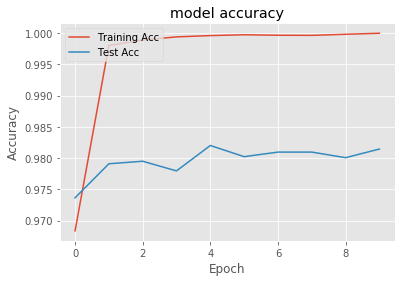

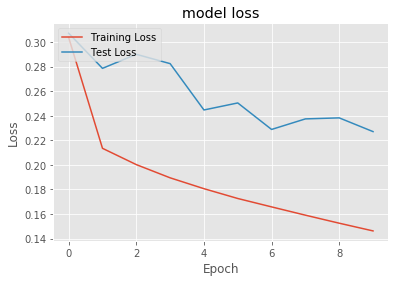

In [11]:
plt.style.use("ggplot")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

# plt.figure()
# N = epochs
# plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
# plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
# plt.title("Training Loss and Accuracy")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="upper left")

In [12]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  0.2579761156439781
Validation Accuracy:  0.97375


In [13]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

22/21 [==============================] - 11s 477ms/step
No of errors = 13/697


Confusion Matrix
[[207   9]
 [  4 477]]


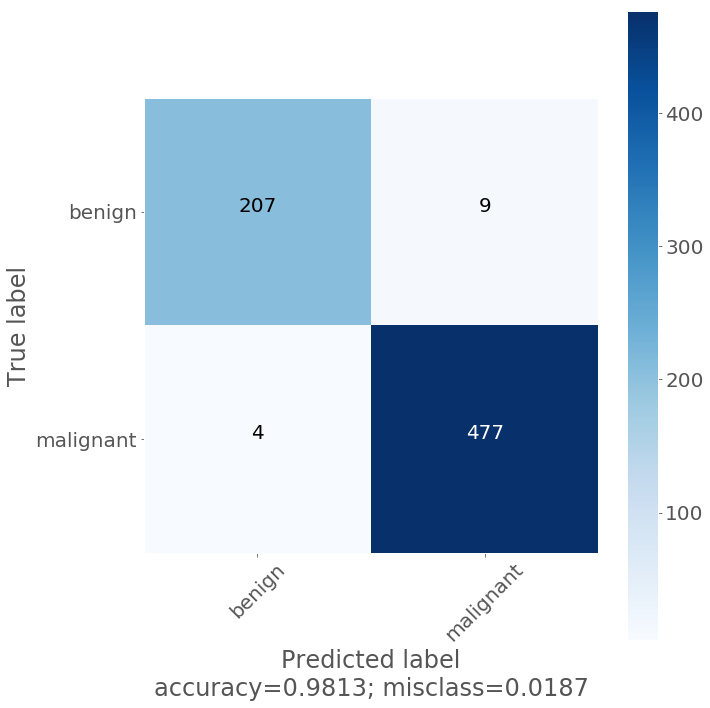

In [14]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels, title=' ')

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[207   9]
 [  4 477]]
              precision    recall  f1-score   support

      benign       0.98      0.96      0.97       216
   malignant       0.98      0.99      0.99       481

   micro avg       0.98      0.98      0.98       697
   macro avg       0.98      0.98      0.98       697
weighted avg       0.98      0.98      0.98       697



In [16]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  98.13486370157818
Sensitivity :  98.10426540284361
Specificity :  98.14814814814815


In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

th = 0.3

acc = accuracy_score(truth,predict_class > th)
prec = precision_score(truth,predict_class > th)
f1 = f1_score(truth,predict_class > th)
recall = recall_score(truth,predict_class > th)

print('Accuracy:  {:.4f}'.format(acc*100))
print('Precision: {:.4f}'.format(prec*100))
print('Recall:    {:.4f}'.format(recall*100))
print('F1:        {:.4f}'.format(f1*100))

Accuracy:  98.1349
Precision: 98.1481
Recall:    99.1684
F1:        98.6556


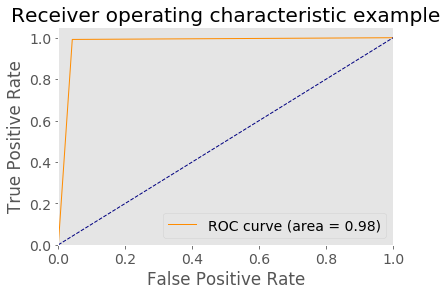

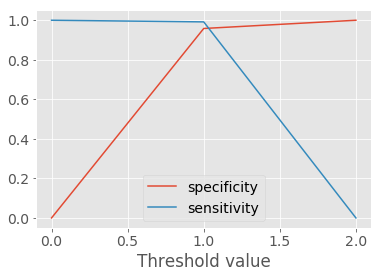

In [18]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 14})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_generator.classes, predict_class)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [19]:
model.save('models/12.InceptionResNetV2-BreaKHis-Model.h5')
model.save_weights('models/12.InceptionResNetV2-BreaKHis-Weights.h5')

___

In [20]:
adam_opt2=Adam(lr=1e-05, beta_1=0.6, beta_2=0.9, epsilon=None, decay=0.0, amsgrad=True)
model.compile(optimizer= adam_opt2, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [21]:
callbacks = [EarlyStopping(monitor='val_acc', patience=5, verbose = 1)]

history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = validation_generator,
  validation_steps = nb_validation_samples // batch_size,
  callbacks = callbacks)

# with open('models/vgg19_history2.txt','w') as f:
#     f.write(str(history.history))

Epoch 1/50
3222/3222 [==============================] - 1513s 470ms/step - loss: 0.1327 - acc: 0.9999 - val_loss: 0.2105 - val_acc: 0.9815
Epoch 2/50
3222/3222 [==============================] - 1498s 465ms/step - loss: 0.1259 - acc: 1.0000 - val_loss: 0.2088 - val_acc: 0.9816
Epoch 3/50
3222/3222 [==============================] - 1484s 461ms/step - loss: 0.1221 - acc: 1.0000 - val_loss: 0.2074 - val_acc: 0.9806
Epoch 4/50
3222/3222 [==============================] - 1485s 461ms/step - loss: 0.1203 - acc: 0.9999 - val_loss: 0.2033 - val_acc: 0.9810
Epoch 5/50
3222/3222 [==============================] - 1498s 465ms/step - loss: 0.1175 - acc: 1.0000 - val_loss: 0.2027 - val_acc: 0.9808
Epoch 6/50
3222/3222 [==============================] - 1494s 464ms/step - loss: 0.1160 - acc: 0.9999 - val_loss: 0.2000 - val_acc: 0.9806
Epoch 7/50
3222/3222 [==============================] - 1497s 465ms/step - loss: 0.1146 - acc: 1.0000 - val_loss: 0.1991 - val_acc: 0.9812
Epoch 00007: early stopping

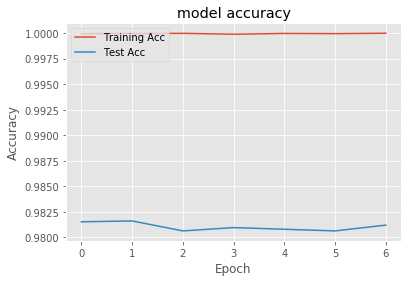

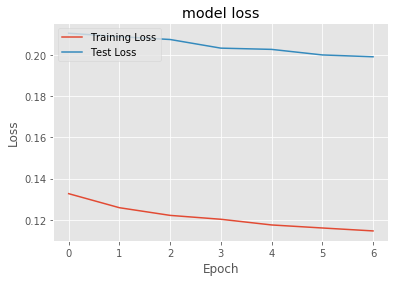

In [22]:
plt.style.use("ggplot")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

# plt.figure()
# N = 12
# plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
# plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
# plt.title("Training Loss and Accuracy")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="upper left")

In [23]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  0.19325817808508872
Validation Accuracy:  0.979375


In [24]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

22/21 [==============================] - 10s 450ms/step
No of errors = 12/697


Confusion Matrix
[[207   9]
 [  3 478]]


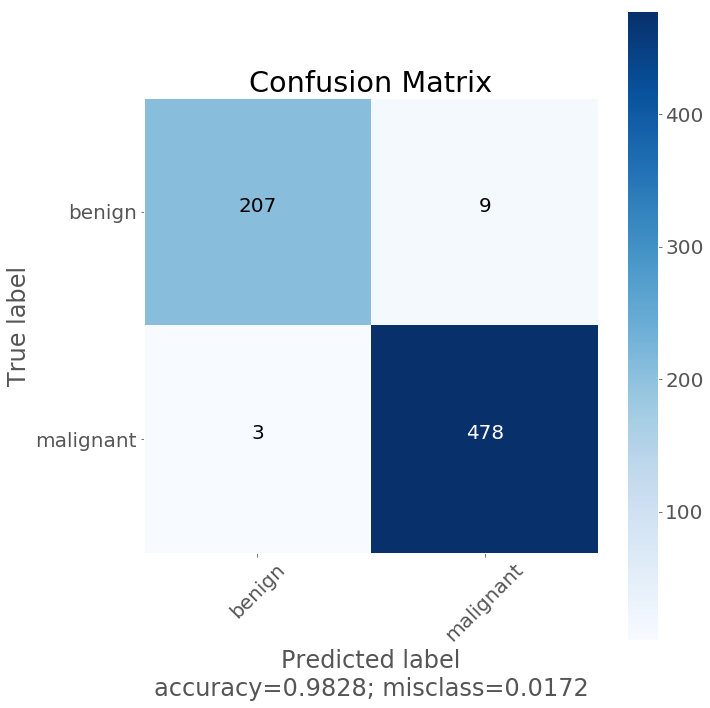

In [25]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
# fig.savefig('plots/1.Xception-CM.png') 
plt.figure(figsize=(10,10))

plot_confusion_matrix(cm, classes=labels, title='Confusion Matrix')

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report


y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[207   9]
 [  3 478]]
              precision    recall  f1-score   support

      benign       0.99      0.96      0.97       216
   malignant       0.98      0.99      0.99       481

   micro avg       0.98      0.98      0.98       697
   macro avg       0.98      0.98      0.98       697
weighted avg       0.98      0.98      0.98       697



In [27]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  98.27833572453372
Sensitivity :  98.57142857142858
Specificity :  98.15195071868584


In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

th = 0.3

acc = accuracy_score(truth,predict_class > th)
prec = precision_score(truth,predict_class > th)
f1 = f1_score(truth,predict_class > th)
recall = recall_score(truth,predict_class > th)

print('Accuracy:  {:.4f}'.format(acc*100))
print('Precision: {:.4f}'.format(prec*100))
print('Recall:    {:.4f}'.format(recall*100))
print('F1:        {:.4f}'.format(f1*100))

Accuracy:  98.2783
Precision: 98.1520
Recall:    99.3763
F1:        98.7603


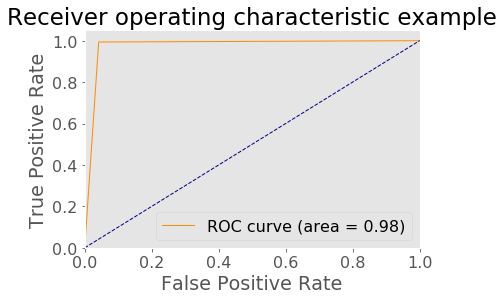

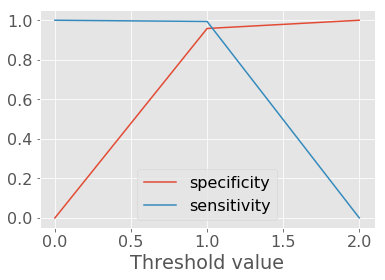

In [29]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 16})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_generator.classes, predict_class)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [30]:
model.save('models/12.InceptionResNetV2-2-BreaKHis-Model.h5')
model.save_weights('models/12.InceptionResNetV2-2-BreaKHis-Weights.h5')

___